# Simple Python Demo

© 2020 By The Rector And Visitors Of The University Of Virginia

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# **Outline**

    1.) Upload data to the framework
    2.) Retreive metadata of an uploaded object using MDS
    3.) Create metadata for contiainer to run job
    4.) Run the uploaded script on the uploaded data using the user provided container
    5.) View the created file and evidence supporting it

## **Service Defintions**

    Metadata Service (MDS): Handles minting/resolving identifiers.
    Transfer Service: Used to upload data with associated metadata to framework
    Compute Service: Runs compuations on uploaded data.
    Evidence Graph Service: Queries Stardog to build Evidence Graph tracking object proveance

## Microservices Model

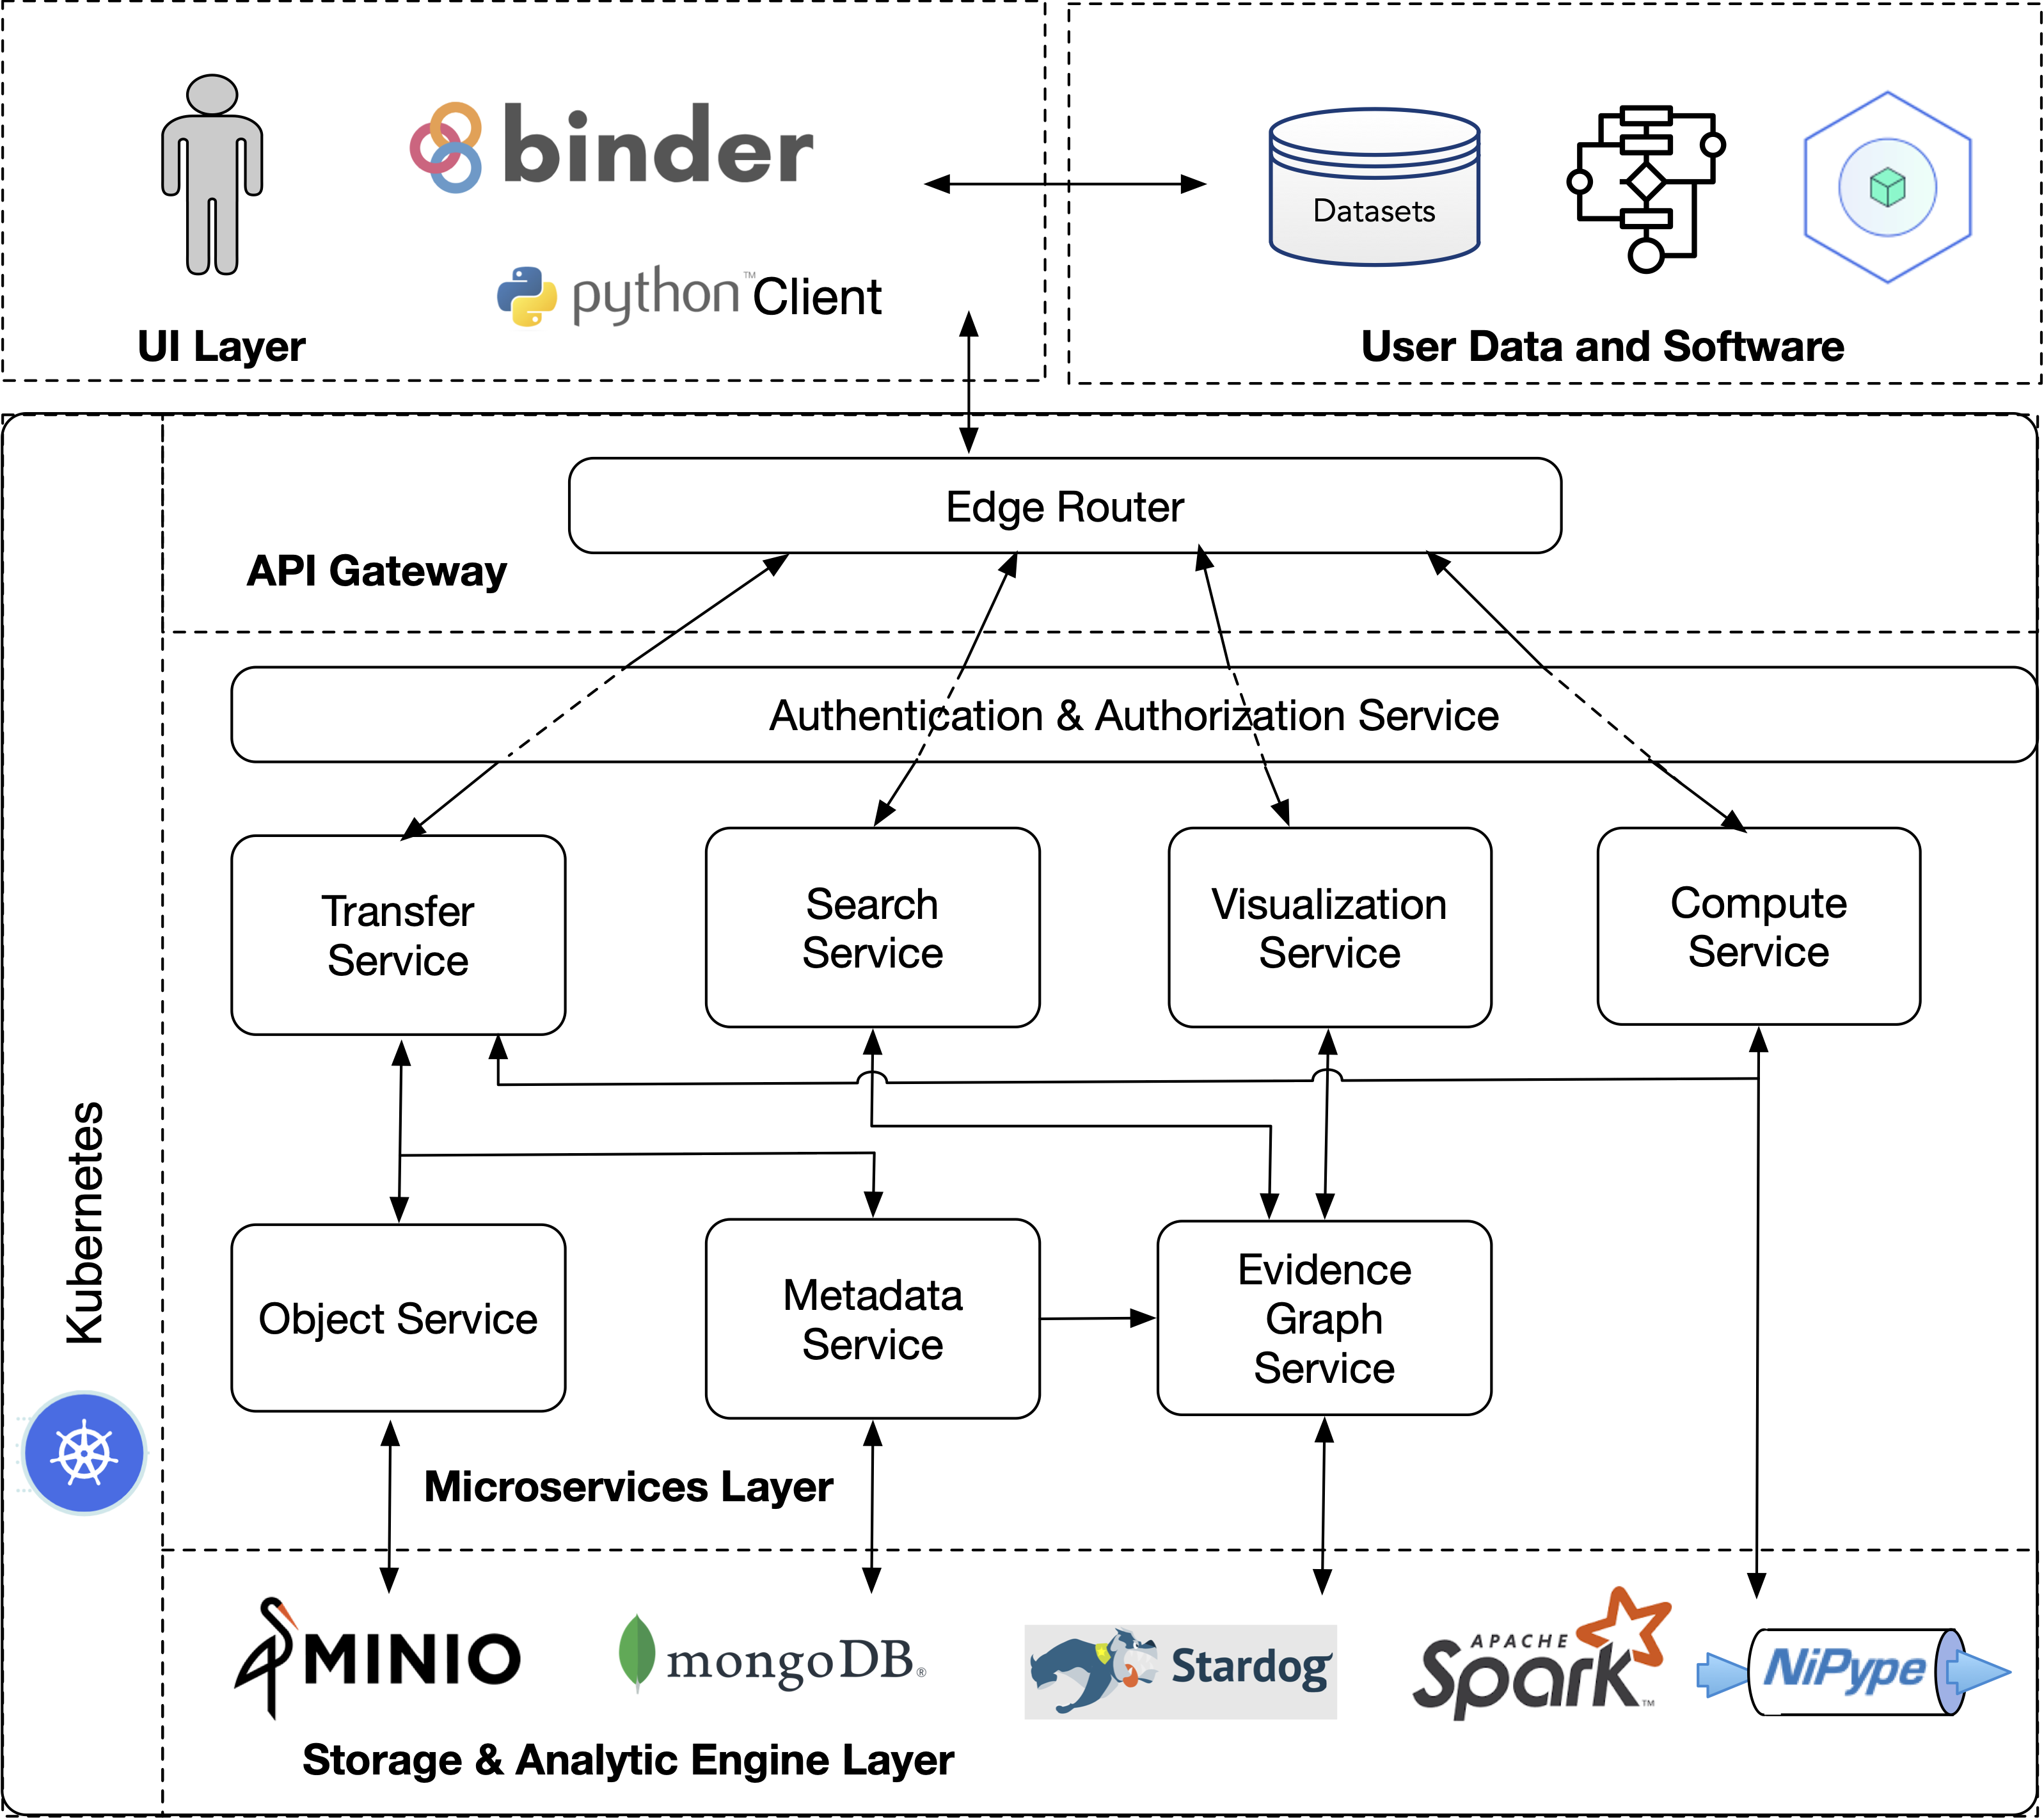

In [1]:
from IPython.display import Image
Image(filename="./Microservice Framework v7.png")

In [ ]:
import requests, jwt,json 
import FAIR

## Create token

In [ ]:
token =  jwt.encode({'name': 'Admin','role':'admin','sub':'admin-id','groups':['test'],'aud':'https://fairscape.org'}, 'test secret', algorithm='HS256')

## Using Transfer Service upload data with metadata

Upload a file to minio via the upload_file function.
<br>
<br>
upload_file takes:
        - file_path: path to local file 
        - metadata: describes the file to be uploaded
returns:
    - PID representing object
upload_file then calls the transfer service which uploads the file to minio and metadata to mongoDB and Stardog

In [ ]:
dataset_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"Dataset",
    "name":"Random Numbers",
    "description":"Random numbers in a text file.",
    "author":[
        {
            "name":"Justin Niestroy",
            "@id": "https://orcid.org/0000-0002-1103-3882",
            "@type":"Person",
            "affiliation":"University of Virginia"
        }
    ],
}
data_id = FAIR.upload_file('random_numbers.txt',dataset_meta,token = token)
data_id

## Check MDS to make sure metadata was uploaded correctly

retrieve_metadata calls MDS to get the metadata for the newly minted id.
<br>
<br>
retrieve_metadata takes:

- PID: identifier of interest

returns:
   
   - json-ld metadata of given PID

In [ ]:
FAIR.retrieve_metadata(data_id,token = token)

## Upload the script to sum the random numbers uploaded

In [ ]:
code_meta = {
    "@context":{
        "@vocab":"http://schema.org/"
    },
    "@type":"SoftwareSourceCode",
    "name":"Sum Script",
    "description":"Script takes in txt file of numbers sums them and writes total to another text file.",
    "author":[
        {
            "name":"Justin Niestroy",
            "@id": "https://orcid.org/0000-0002-1103-3882",
            "@type":"Person",
            "affiliation":"University of Virginia"
      }
    ]
}
software_id = FAIR.upload_file('sum_script.py',code_meta,token = token)
software_id

## Create identifier for docker container to run the script
In order to run a job using any user created container the container must be uploaded to docker hub. The user must then create an identifier with the tag 'image' pointing to the container name. 

In [ ]:
container_meta = {
    '@type':'evi:Software',
    'name':'Vanilla python container.',
    'image':'python'
}

container_id = FAIR.mint_id(container_meta,token=token)

## Submit Job Using Compute Service

Run a the uploaded script on the uploaded data by calling compute
<br>
<br>
FAIR.compute takes: 
   - data pid 
   - software pid
   - type of job ie spark, nipype, and custom  
   - container id (id with pointer to container in docker hub)
   - command (command to be run inside the container)
  
<br>
compute then launches kubernetes pods to run the given script on the provided data using specialized pods
<br>
<br>
compute returns:

  - job_PID 

In [ ]:
job_id = FAIR.compute(data_id,software_id,'custom',container_id,command = 'python3',token = token)
job_id

## Watch Running Job
list_running_jobs takes:
<br>
<br>
list_running_jobs returns:
   
   - list of running job PIDs

In [ ]:
FAIR.list_running_jobs(token = token)

> Warning: Must wait unitl job is completed to move on!

## Get Job outputs from job metadata

Upon completion of a job the compute service updates the job id metadata to include properties:
    - evi:supports: list of output PIDs 
    - logs: logs from job

In [ ]:
job_metadata = FAIR.retrieve_metadata(job_id,token = token)
output_ids = job_metadata.get('evi:supports')
output_ids

The computation created an output
<br>
Metadata for the created output is shown below

In [ ]:
output_metadata = [ 
   FAIR.retrieve_metadata(out,token = token) for out in output_ids
]
output_id = output_ids[0]
output_metadata

## Download Created Text File

Download output files from computations using download_file
<br>
<br>
download_file takes:
   
   - PID: id representing object to be downloaded
   - name: file name for downloaded object
<br>

download_file returns:<br>
   
   - bool: True if download if succesful<br>
   - file saved location given

In [ ]:
FAIR.download_file(output_id,'sum.txt',token = token)

### Build Evidence graph of created text file using the evidence graph service

Evidence Graph Service builds an json-ld evidence graph representing the provenance (datasets, software, and computations that support the PID)
<br>
<br>
evidence_graph takes:
   - PID

evidence_graph returns:
   - json-ld evidence graph for given PID

In [ ]:
FAIR.evidence_graph(output_id,token = token)

## View Visualization of the Evidence Graph

Visit link below to view the evidence graph for the created image!

In [ ]:
'http://localhost:5000/' + output_id